### Load data

In [1]:
from sklearn import datasets
import pandas as pd
pd.set_option('display.max_columns', None)
import sys
sys.path.append('../../')

diabetes = datasets.load_diabetes()
data = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
target = pd.Series(diabetes.target)
df = pd.concat([data, target], axis=1)
df.columns.values[-1] = 'target'

### Initialize a TabularMagic object

In [2]:
from tabularmagic.api import TabularMagic
tm = TabularMagic(df, test_size=0.2, name='Diabetes scikit-learn dataset')
tm

INFO: Initialization complete. Shapes of train, test DataFrames: (353, 11), (89, 11). 


Diabetes scikit-learn dataset 
----------------------------------------------------------------------------------------------------
Train shape: (353, 11)                             Test shape: (89, 11)                             
----------------------------------------------------------------------------------------------------
Categorical variables:
  None 
                                                                                                    
Continuous variables:
  age, sex, bmi, bp, s1, s2, s3, s4, s5, s6, target 

### Preprocessing

Force sex to binary (0-and-1-valued continuous) variables

In [3]:
tm.datahandler().force_binary(['sex'])

INFO: Forced variables sex to binary. 


Diabetes scikit-learn dataset 
----------------------------------------------------------------------------------------------------
Train shape: (353, 11)                             Test shape: (89, 11)                             
----------------------------------------------------------------------------------------------------
Categorical variables:
  None 
                                                                                                    
Continuous variables:
  age, sex, bmi, bp, s1, s2, s3, s4, s5, s6, target 

### Conduct exploratory analysis

Visualize the distribution of the target variable statified by sex

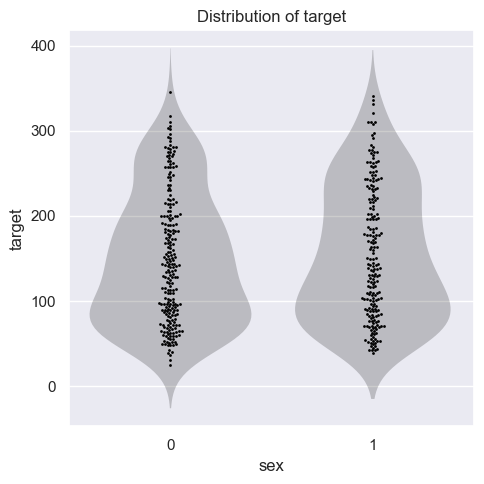

In [4]:
tm.eda(dataset='all').plot_distribution_stratified(
    'target', 'sex', strategy='violin_swarm')

Visualize the distribution of the target variable in relation with bmi, age, bp

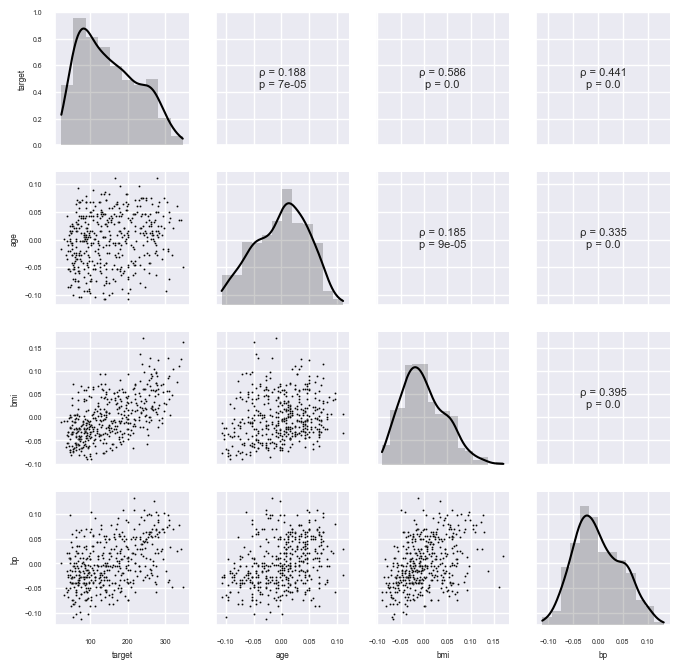

In [5]:
tm.eda(dataset='all').plot_continuous_pairs(
    continuous_vars=['target', 'age', 'bmi', 'bp']
)

### Regression analysis

In [6]:
lm_report = tm.lm(
    formula='target ~ age + bmi'
)
lm_report.statsmodels_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     137.5
Date:                Sat, 25 May 2024   Prob (F-statistic):           8.33e-45
Time:                        01:56:55   Log-Likelihood:                -1956.1
No. Observations:                 353   AIC:                             3918.
Df Residuals:                     350   BIC:                             3930.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        151.8365      3.295     46.087      0.000     145.379     158.294
age          147.9397     73.767      2.006      0.045       3.360     292.519
bmi          971.7979     65.338     14.873      0.000     843.739    1099.857
==============================================================================
Omnibus:                       13.231   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                6.775
Skew:                           0.110   Prob(JB):                       0.0338
Kurtosis:                       2.358   Cond. No.                         23.7
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

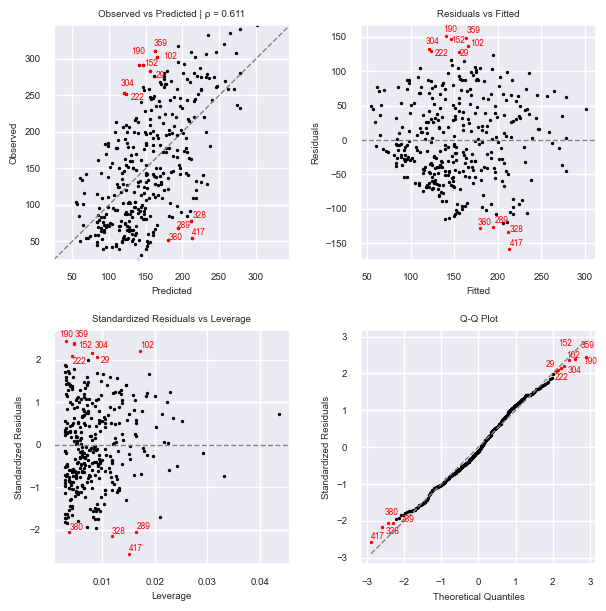

In [7]:
lm_report.train_report().set_outlier_threshold(2).plot_diagnostics(
    show_outliers=True)

In [8]:
lm_report.train_report().fit_statistics()

,OrdinaryLeastSquares_train
Statistic,
rmse,61.715945
mad,51.515233
pearsonr,0.610878
spearmanr,0.584544
r2,0.373172
adjr2,0.36959
n,353


In [9]:
lm_report.test_report().fit_statistics()

,OrdinaryLeastSquares_test
Statistic,
rmse,63.661412
mad,52.72513
pearsonr,0.51112
spearmanr,0.511673
r2,0.235059
adjr2,0.217269
n,89


### Machine learning regression benchmarking

Each model performs a grid search to find optimal estimator. Nested k-fold cross validation is performed to assess model fit on train. Models are also assesed on test.

In [11]:
from tabularmagic.api.mlR import (
    TreeEnsembleR,
    SVMR,
    LinearR,
    MLPR,
)

ml_report = tm.ml_regression(
    models=[
        LinearR('ols'),
        LinearR('l1'),
        LinearR('l2'),
        SVMR('rbf', n_jobs=-1),
        TreeEnsembleR('adaboost', n_jobs=-1),
        MLPR()
    ],
    y_var='target',
    X_vars=['age', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'],
    outer_cv=5,
    outer_cv_seed=0
)

INFO: Fitting model LinearR(ols). 
INFO: Fitted model LinearR(ols). 
INFO: Fitting model LinearR(l1). 
INFO: Fitted model LinearR(l1). 
INFO: Fitting model LinearR(l2). 
INFO: Fitted model LinearR(l2). 
INFO: Fitting model SVMR(rbf). 
INFO: Fitted model SVMR(rbf). 
INFO: Fitting model TreeEnsembleR(adaboost). 
INFO: Fitted model TreeEnsembleR(adaboost). 
INFO: Fitting model MLPR. 
INFO: Fitted model MLPR. 


View averaged fit statistics across folds

In [12]:
ml_report.fit_statistics('train')

,LinearR(ols)_train_cv,LinearR(l1)_train_cv,LinearR(l2)_train_cv,SVMR(rbf)_train_cv,TreeEnsembleR(adaboost)_train_cv,MLPR_train_cv
Statistic,,,,,,
rmse,55.922637,56.300856,56.1589,56.638801,60.713838,59.298803
mad,45.70565,46.144134,45.98105,46.373491,48.39716,49.750436
pearsonr,0.704438,0.699251,0.701216,0.700341,0.646174,0.663402
spearmanr,0.679914,0.677564,0.676843,0.670575,0.636187,0.644952
r2,0.475706,0.468273,0.470999,0.462651,0.379449,0.410322
adjr2,0.397786,0.389243,0.392374,0.382802,0.287198,0.322691
n,70.6,70.6,70.6,70.6,70.6,70.6


View fit statistics for each fold

In [13]:
ml_report.cv_fit_statistics()

LinearR(ols)_train_cv LinearR(l1)_train_cv  \
Fold Statistic                                              
0    rmse                  58.010997            58.494235   
     mad                    47.43226            47.935861   
     pearsonr               0.705315             0.697707   
     spearmanr              0.695095             0.688421   
     r2                     0.482068             0.473403   
     adjr2                  0.405652             0.395709   
     n                            71                   71   
1    rmse                  58.221287            58.219826   
     mad                   48.916372            48.915907   
     pearsonr               0.692283             0.692303   
     spearmanr              0.665487             0.665487   
     r2                     0.468511             0.468538   
     adjr2                  0.390095             0.390125   
     n                            71                   71   
2    rmse                  50.304187            50.383579   
     mad                   39.900148            40.061868   
     pearsonr               0.766077             0.768472   
     spearmanr              0.723024             0.735483   
     r2                     0.578251             0.576919   
     adjr2                  0.516026             0.514497   
     n                            71                   71   
3    rmse                  57.482488            58.813103   
     mad                   47.225446            48.753206   
     pearsonr               0.654464             0.633718   
     spearmanr              0.660437             0.642905   
     r2                     0.419045             0.391837   
     adjr2                  0.331901             0.300613   
     n                            70                   70   
4    rmse                  55.594227            55.593537   
     mad                   45.054025            45.053827   
     pearsonr                0.70405             0.704056   
     spearmanr              0.655526             0.655526   
     r2                     0.430656              0.43067   
     adjr2                  0.345254              0.34527   
     n                            70                   70   

               LinearR(l2)_train_cv SVMR(rbf)_train_cv  \
Fold Statistic                                           
0    rmse                 58.305219          60.007916   
     mad                  48.090109          48.959942   
     pearsonr              0.701529           0.698101   
     spearmanr             0.686778           0.685856   
     r2                    0.476801           0.445797   
     adjr2                 0.399608           0.364029   
     n                           71                 71   
1    rmse                 58.091915          58.106913   
     mad                   48.88081          48.867364   
     pearsonr               0.69408           0.703244   
     spearmanr             0.667718           0.665638   
     r2                    0.470871           0.470597   
     adjr2                 0.392802           0.392489   
     n                           71                 71   
2    rmse                 50.329886          51.795526   
     mad                  39.889149          41.461926   
     pearsonr              0.767736           0.769525   
     spearmanr              0.72569           0.729983   
     r2                     0.57782           0.552874   
     adjr2                 0.515531           0.486904   
     n                           71                 71   
3    rmse                 58.474669          60.035554   
     mad                  47.991425          49.286498   
     pearsonr              0.638671           0.616958   
     spearmanr             0.648871           0.619913   
     r2                    0.398816           0.366293   
     adjr2                 0.308639           0.271237   
     n                           70                 70   
4    rmse        

View fit statistics on the withheld testing dataset

In [14]:
ml_report.fit_statistics('test')

,LinearR(ols)_test,LinearR(l1)_test,LinearR(l2)_test,SVMR(rbf)_test,TreeEnsembleR(adaboost)_test,MLPR_test
Statistic,,,,,,
rmse,54.65101,53.863011,54.50193,54.413022,52.919897,56.215125
mad,44.267691,43.826755,44.197353,43.66508,42.586968,46.781418
pearsonr,0.669771,0.675814,0.670675,0.672478,0.687599,0.638443
spearmanr,0.662453,0.664266,0.659848,0.653106,0.639767,0.61857
r2,0.436269,0.452408,0.43934,0.441168,0.471417,0.403539
adjr2,0.372046,0.390024,0.375468,0.377504,0.411198,0.335588
n,89,89,89,89,89,89


View MLPR optimal hyperparameters

In [15]:
ml_report.model('MLPR').hyperparam_searcher().best_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (100, 50, 25),
 'learning_rate': 'constant',
 'solver': 'adam'}

Obtain the scikit-learn estimator

In [16]:
ml_report.model('MLPR').sklearn_estimator()

MLPRegressor(hidden_layer_sizes=(100, 50, 25), random_state=42)

View MLPR fit on train data

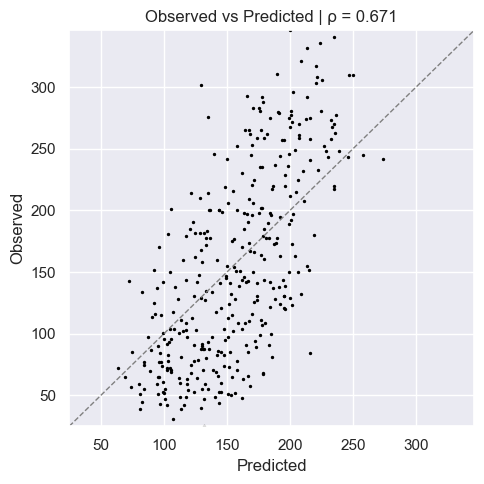

In [17]:
ml_report.model_report('MLPR').train_report().plot_obs_vs_pred()

View MLPR fit on test data

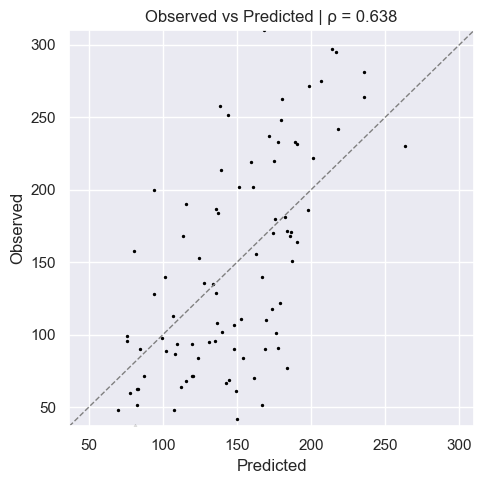

In [18]:
ml_report.model_report('MLPR').test_report().plot_obs_vs_pred()